# Monoaural source separation using NMF with

We minimise the Frobenius norm alone to perform nmf and obtain the source components.

In [2]:
import os
import sys
import numpy as np
import librosa
import scipy
import librosa.display
import matplotlib
from sklearn.decomposition import NMF
from matplotlib import pyplot as plt
from librosa.core import resample
from os import listdir
from os.path import join
from scipy.io.wavfile import write

sys.path.insert(0,"/home/milind/source_separation/nmf")
sys.path.insert(0,"/home/milind/source_separation/tools")
from nmf_local import *
from basic_functions import *

figsize = (10,8)
matplotlib.rcParams.update({'font.size': 22})

In [3]:
path_audio = "/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4.wav"
path_rescaled_components = "/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_rescaled/"

# The audio signal

The audio is created by mixing 7 different instruments. The time domain signal is displayed below.

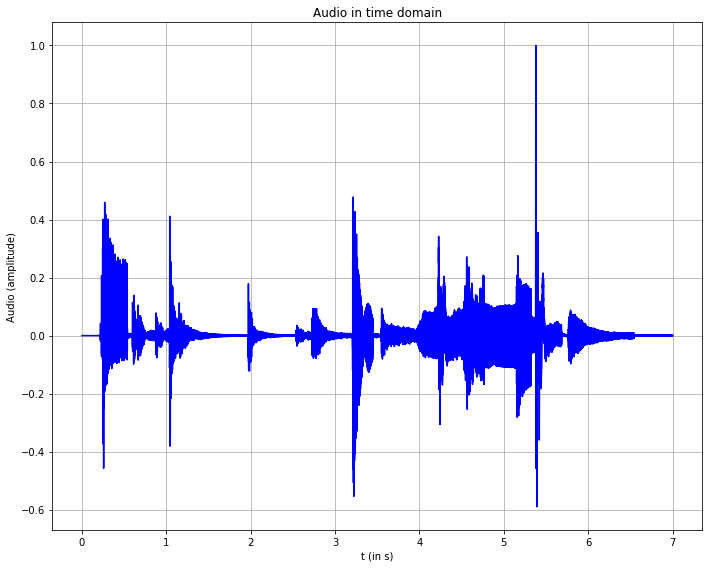

In [4]:
# loading audios
fs_target = 44100
audio, fs = librosa.load(path_audio,sr = fs_target)
# time domain representation
x = np.arange(len(audio))/fs_target
plotfigure(figsize, "t (in s)", "Audio (amplitude)", "Audio in time domain",x,audio,style= "b-" )

The parameters are set using the values provided in the paper [1].

In [5]:
# fft details in time units
frame_size = 40e-3
overlap = 0.5
dft_size = frame_size

# fft details in terms of samples
n_fft = int(frame_size*fs_target)
hop_length = int((1-overlap)*frame_size*fs_target)

# DECISION MADE HERE! for window, center, and reflect 
window = scipy.signal.hanning(n_fft)

# The spectrogram

We obtain a STFT using the specifications provided in [1]. Thus we use a frame size of 40ms and a hop length of 29ms. The sampling rate is 44,100 Hz. A hanning window is used for the STFT.

In [27]:
# mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
# D = librosa.amplitude_to_db(np.abs(mag_spec), ref=np.max)
# librosa.display.specshow(D, y_axis='log', x_axis='time')
# #librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
# plt.show()

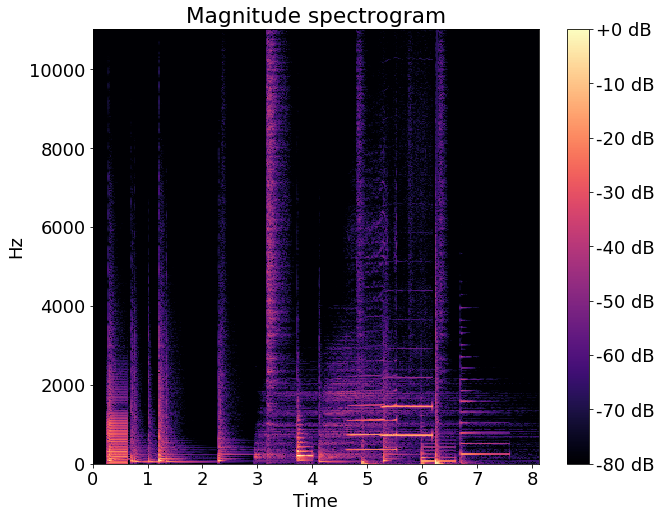

In [28]:
mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
D = librosa.amplitude_to_db(np.abs(mag_spec), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title("Magnitude spectrogram")
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.show()

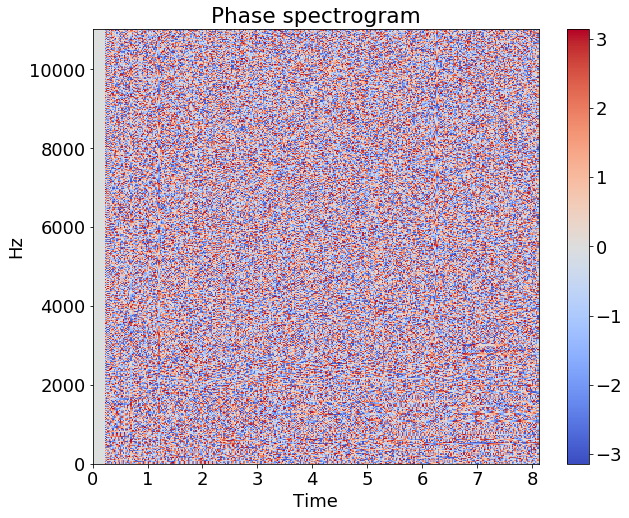

In [29]:
# attempt to plot phase spectrogram

mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
D = np.angle(mag_spec)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title("Phase spectrogram")
plt.colorbar()
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.show()

In [30]:
# # modelling componenets using Least squares norm
# model = NMF(n_components=7, init='random', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
# W = model.fit_transform(np.abs(mag_spec))
# H = model.components_
# # Displaying the reconstructed spectrogram
# librosa.display.specshow(np.dot(W,H), y_axis='log', x_axis='time')

## The reconstructed spectrogram

Once the matrices $W$ amd $H$ are obtained, the magnitude spectrogram is reconstructed as 
\begin{equation}
Magnitude\ Spectrogram = WH
\end{equation}
This is displayed below.

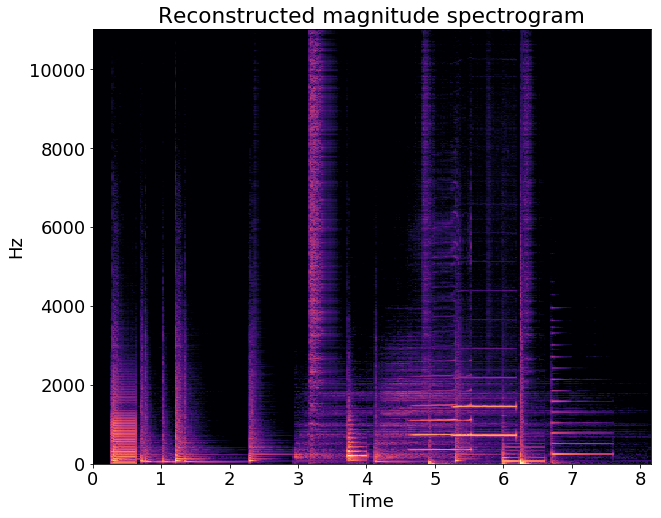

In [31]:
# extra
D = librosa.amplitude_to_db((np.dot(W,H)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.title("Reconstructed magnitude spectrogram")
plt.show()

## The $i^{th}$ component

The magnitude spectrogram for the $i^{th}$ component is obtained. The complex spectrogram is obtained by performing an elementwise product with the phase of the original audio. We then perform an ISTFT to obtain the time domain signal. We also plot the time domain signals for the purpose of representation.

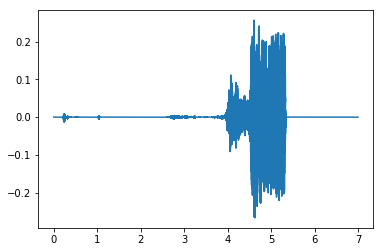

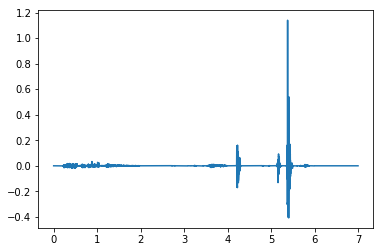

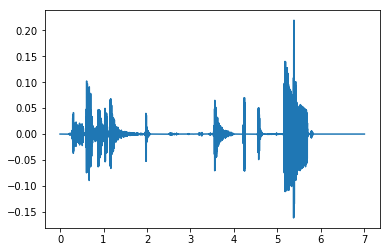

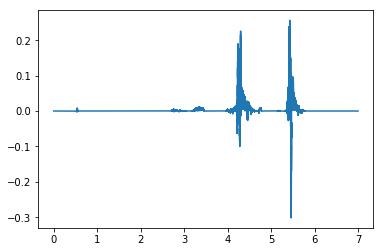

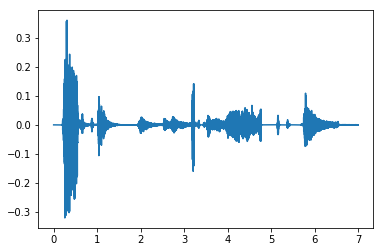

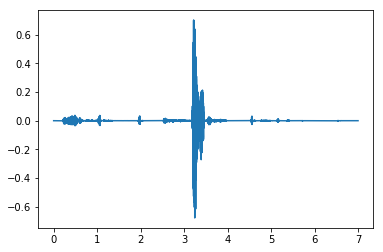

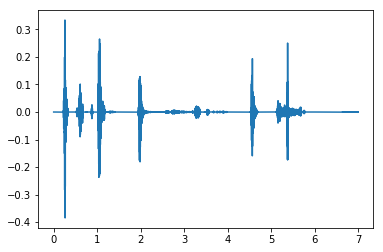

In [11]:
# phase = np.angle(mag_spec)
# n_fft = 2*np.shape(mag_spec)[0]-1
# total = 0
# audios = []
# from scipy.io.wavfile import write
# for i in range(0,np.shape(W)[1]):
#     component= np.outer(W[:,i],(H[i,:]))
#     component = component*phase
#     audio2 = librosa.core.istft(component, hop_length=n_fft//2)
#     audios.append(audio2)
#     plt.figure()
#     plt.plot(x,audio2)
#     total = total + audio2 
#     write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/component" +str(i) + ".wav", 44100, audio2)

phase = np.angle(mag_spec) # phase of the original signal
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(W)[1]):
    component= np.outer(W[:,i],(H[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    plt.figure()
    plt.plot(x,audio2)
    total = total + audio2 
    write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + ".wav", 44100, audio2)
    audio2_rescaled = audio2/ np.max(audio2)
    write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + "_rescaled.wav", 44100, audio2_rescaled)

# The reconstructed audio
We superimpose the original time domain signal and the final reconstructed signal to obtain 

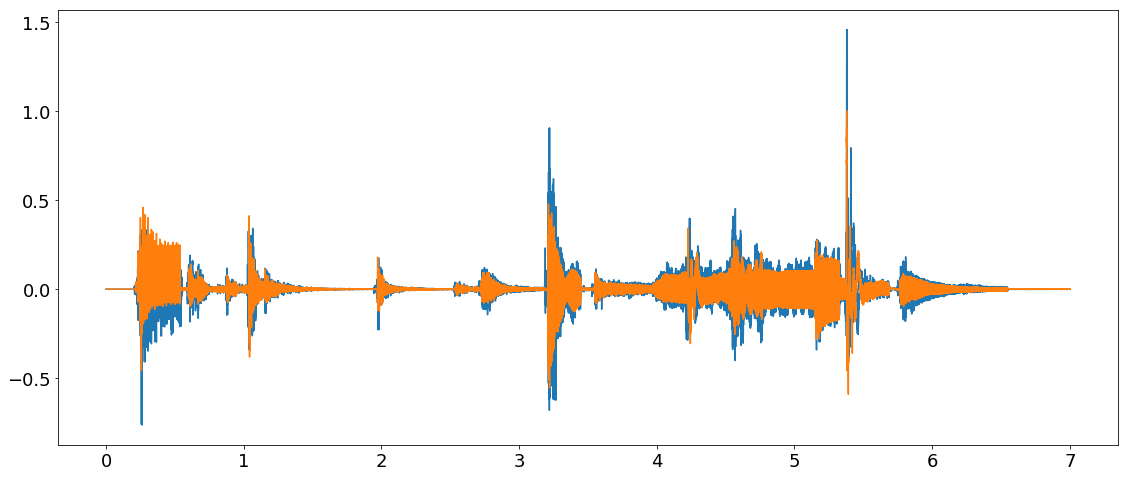

In [32]:
# plotting sum of components and the original signal
plt.figure(figsize = (19,8))
plt.plot(x,total)
plt.plot(x,audio)
plt.show()

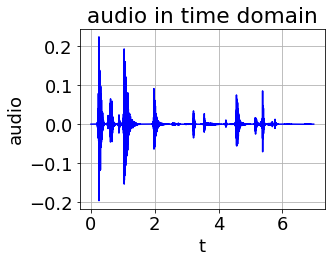

In [14]:
path_audio_separated7 = "/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_separated/separated4-7.wav"
fs_target = 44100
separated7, fs = librosa.load(path_audio_separated7,sr = fs_target)
y = np.arange(0,len(separated7)/fs_target,1/fs_target)
# time domain representation
plotfigure((5,4), "t", "audio", "audio in time domain",y,separated7,style= "b-" )

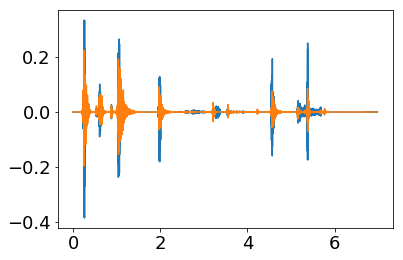

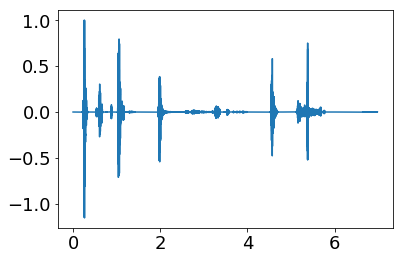

In [15]:
# comparing similar looking components
component7 = audios[6][:len(y)]
plt.figure(figsize = (6,4))
plt.plot(y,component7)
plt.plot(y,separated7)
write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_rescaled/component7.wav", 
       44100, component7)
# increasing magnitude
plt.show()
plt.figure(figsize = (6,4))
component7_rescaled = component7/np.max(component7)
plt.plot(y,component7_rescaled)
plt.show()
write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_rescaled/component7_rescaled.wav", 
       44100, component7_rescaled)

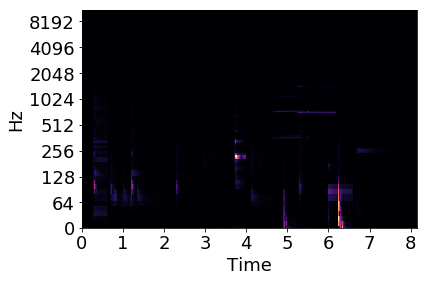

In [16]:
# modelling componenets using Least squares norm
model = NMF(n_components=340, init='random', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
W = model.fit_transform(np.abs(mag_spec))
H = model.components_
# Displaying the reconstructed spectrogram
librosa.display.specshow(np.dot(W,H), y_axis='log', x_axis='time')

In [17]:
phase = np.angle(mag_spec)
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(W)[1]):
    component= np.outer(W[:,i],(H[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


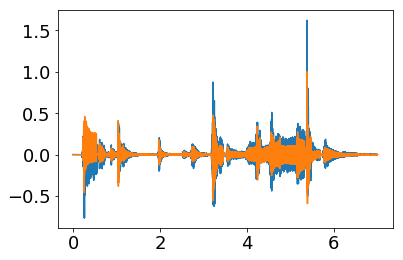

In [18]:
plt.plot(x,total)
plt.plot(x,audio)
plt.show()

In [19]:
print(len(audios))

340


In [20]:
from sklearn.cluster import KMeans

In [21]:
magnitude = np.abs(mag_spec)
nonzero = np.nonzero(magnitude)
minval = (np.min(magnitude[nonzero]))
alpha = minval/1000

In [22]:
corrected = magnitude + alpha

In [23]:
B,G,_ = divfind(corrected,7,1000,50)

cost after 50 iterations: 7984.649643349916
cost after 100 iterations: 7929.561396004065
cost after 150 iterations: 7923.713388059554
cost after 200 iterations: 7923.062479962318
cost after 250 iterations: 7922.658051870065
cost after 300 iterations: 7922.435075745274
cost after 350 iterations: 7922.332617797576
cost after 400 iterations: 7922.254872033496
cost after 450 iterations: 7922.224114047909
cost after 500 iterations: 7922.204914090686
cost after 550 iterations: 7922.1767955770265
cost after 600 iterations: 7922.096942246491
cost after 650 iterations: 7922.0251518317855
cost after 700 iterations: 7921.976610951428
cost after 750 iterations: 7921.953871872123
cost after 800 iterations: 7921.946126666411
cost after 850 iterations: 7921.9423133578675
cost after 900 iterations: 7921.936005612406
cost after 950 iterations: 7921.934371685464
cost after 1000 iterations: 7921.93362498737


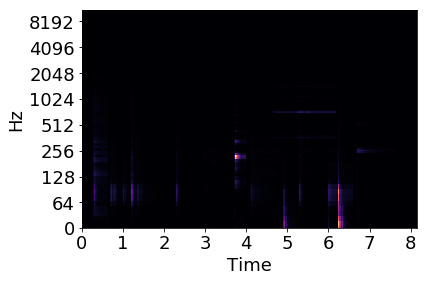

In [24]:
librosa.display.specshow(np.dot(B,G), y_axis='log', x_axis='time')

In [25]:
phase = np.angle(mag_spec)
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(B)[1]):
    component= np.outer(B[:,i],(G[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


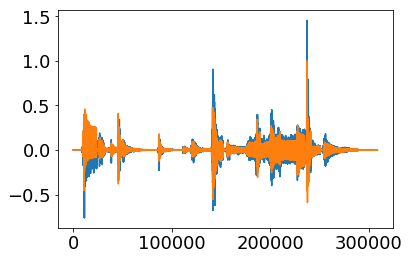

In [26]:
plt.plot(total)
plt.plot(audio)